<a href="https://colab.research.google.com/github/ele9996/Heart-failure-clinical-records-analysis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Import useful libraries


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random as rand

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import svm
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from numpy import mean

#np.random.seed(123)

##Defining metrics for conclusion table

In [58]:
acc_original=[0,0,0,0]
acc_smote=[0,0,0,0]
f1_original=[0,0,0,0]
f1_smote=[0,0,0,0]
f1_original_cv=[0,0,0,0]
f1_smote_cv=[0,0,0,0]
acc_original_cv=[0,0,0,0]
acc_smote_cv=[0,0,0,0]

#Heart failure data analysis
#Introduction

The goal of the project is to try to predict if a patient with heart failure is likely to survive or not given certain medical records regarding clinical, body and lifestyle information.

Heart failure (HF) is a illness that occurs when the heart cannot pump enough blood to meet the needs of the body.

In order to try to make predictions about this topic I took into consideration a dataset containing the medical records of 299 heart failure patients collected both at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015.

The subject taken into consideration for my study are 105 women and 194 men whose age range in between 40 and 90.

The dataset analyzed contains the medical records of 299 heart failure patients consisting of 105 women and 194 men whoes ages range between 40 and 95 years old.

In this project several classifiers will be tested in order to obtain the best results and several machine learning tecniques will be applied to the data in order to get the best out of them 


#Dataset description
The first step to start the analysis is studing the overall characteristics of the dataset.
A summary them is provided by the following table:


 ![Dataset Description](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/dataset_characteristics.JPG?raw=true)





From the table it is possible to notice the presence of 299 entries all defined by Integer or real numbers.
The description states also that there are no missing value in the collection.

The dataset is composed by 13 total features.
The first 12 represent the real features on which the analysis is based while the last one (DEATH_EVENT) represents the target variable.

In order to better understand the meaning of the features in their domain field and to quantifity them better another table containing this information is provided.


In particular the table contains a description of every feature in the dataset. 

Also other information like the unit of measurement and the range to which each feature belongs are given.


![feature Description](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/feature_description.JPG?raw=true)


#Dataset visualization and data exploration


After understanding the features characterizing the dataset it's time to have a closer look at the entries.

The following table provides a sample visualization of the data:



In [59]:
#Dataset import and graphical visualization
df = pd.read_csv('https://raw.githubusercontent.com/ele9996/Heart-failure-clinical-records-analysis/master/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


After fouther analysis it is possible to notice the presence of both categorical features and numerical features.

The categorical features are: 


*   anaemia
*   diabetes
*   high_blood_pressure
*   sex
*   smoking
*   DEATH_EVENT(target variable)

All categorical features are binary (yes/no) features and are encoded in (0-1) notation

The numerical features are:


*   age
*   creatinine_phosphokinase
*   ejection_fraction
*   platelets
*   serum_creatinine
*   serum_sodium
*   time


Since the target variable is categorical, the problem is binary and so an analysis based on binary classification will be performed.

##Null entries check
According to what the dataset description says there shouldn't be null entries in the collections.

But since handling clean data is a priority in the analysis in order to not alterate results, a fourther check will be performed.


In [60]:
df.isnull().values.any()

False

As we can see from the output of the previous code the description statement was correct and there are no null entries in the dataset.
Since data seems to be consistent and right recorder no further data cleaning measurements are needed

##Correlation study
In order to know more informations about the attributes and to analyze them better it's important to study their mutual relationships.

One important relation worth considering is the **correlation** between attributes.

Correlation is a function of another quantity called the **covariance** whose formula is reported below:

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$

Covariance provides us information about trends in data which can be: 
- ascending trend ($cov_{x,y}>0$)
- descending trend ($cov_{x,y}<0$)
- no trend ($cov_{x,y}=0$)

Even if covariance seems to be a good measure to estimate relationship between data it is not: in fact covariance is highly dependent on the scale of the data 
and so it's interpretation may result very difficult.

However Correlation is extremely important in the calculation of the Pearson correlation between attributes.

Pearson correlation is a quantity that ranges between -1 and +1 and defines the degree to which a pair of variables are linearly related. 

It is a good measure in estimating data relationships because doesn't depend on the scale of the data.

The formula for calculating correlation is provided below: 


${\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\displaystyle \rho _{X,Y}={\frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}}}$

A visual representation of correlation is provided by the following figure:

![correlation](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/correlation.JPG?raw=true)


To study Correlation between features in my data and in order to visualize them better a **Correlation Matrix** containing correlation coefficients is displayed below.

Since categorical variables are encoded in 0-1 notation it is possible to apply Pearson correlation also to them.

This kind of correlation is called "Point Biserial Correlation".

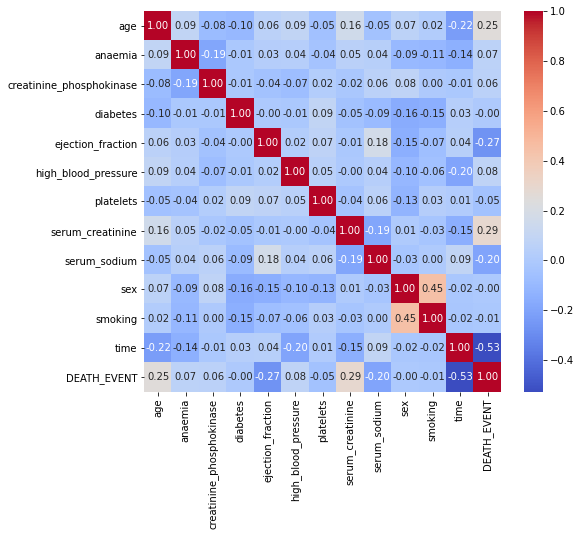

In [61]:
#I calculate correlation and print the correlation matrix
corr = df.corr()
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax,cmap='coolwarm')



In the heatmap it is possible to notice two main colors: Red and Blue.

The higher the correlation index becomes the closer the cell color tends to be red.

In the matrix it is possible to notice that there are no attributes that are significantly correlated.



##Data preparation

In [62]:
#to function

features = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']
numerical_features=[features[0],features[2],features[4],features[6],features[7],features[8],features[11]]
categorical_features=[features[1],features[3],features[5],features[9],features[10]]

#Taking the features and placing in an array
x = df.loc[:, features].values
x_numerical=df.loc[:,numerical_features].values

x_categorical=df.loc[:,categorical_features].values

#Separating the target
y = df.loc[:,['DEATH_EVENT']].values#



x_Df = pd.DataFrame(data = x, columns = features)
x_numerical_Df = pd.DataFrame(data = x_numerical, columns = numerical_features)
x_categorical_Df = pd.DataFrame(data = x_categorical, columns = categorical_features)
y_df=pd.DataFrame(data = y, columns = ['DEATH_EVENT'])





#Features distribution visualization
Another characteristic of the dataset worth studying is the features distribution over the target variable "DEATH_EVENT".

In this chapter a distinction between numerical and categorical features is performed in terms of visualization.

In particular for **numerical** features, in order to detect the presence of outliers, a **boxplot** seems to be the most appropriate choice.

Concerning **categorical** features a **countplot/barplot** seems to be is

For both categorical and numerical features a plot of the distibution is given.


###Numerical features
The following images contain the distribution of each numerical features with respect to the target variable "DEATH_EVENT"

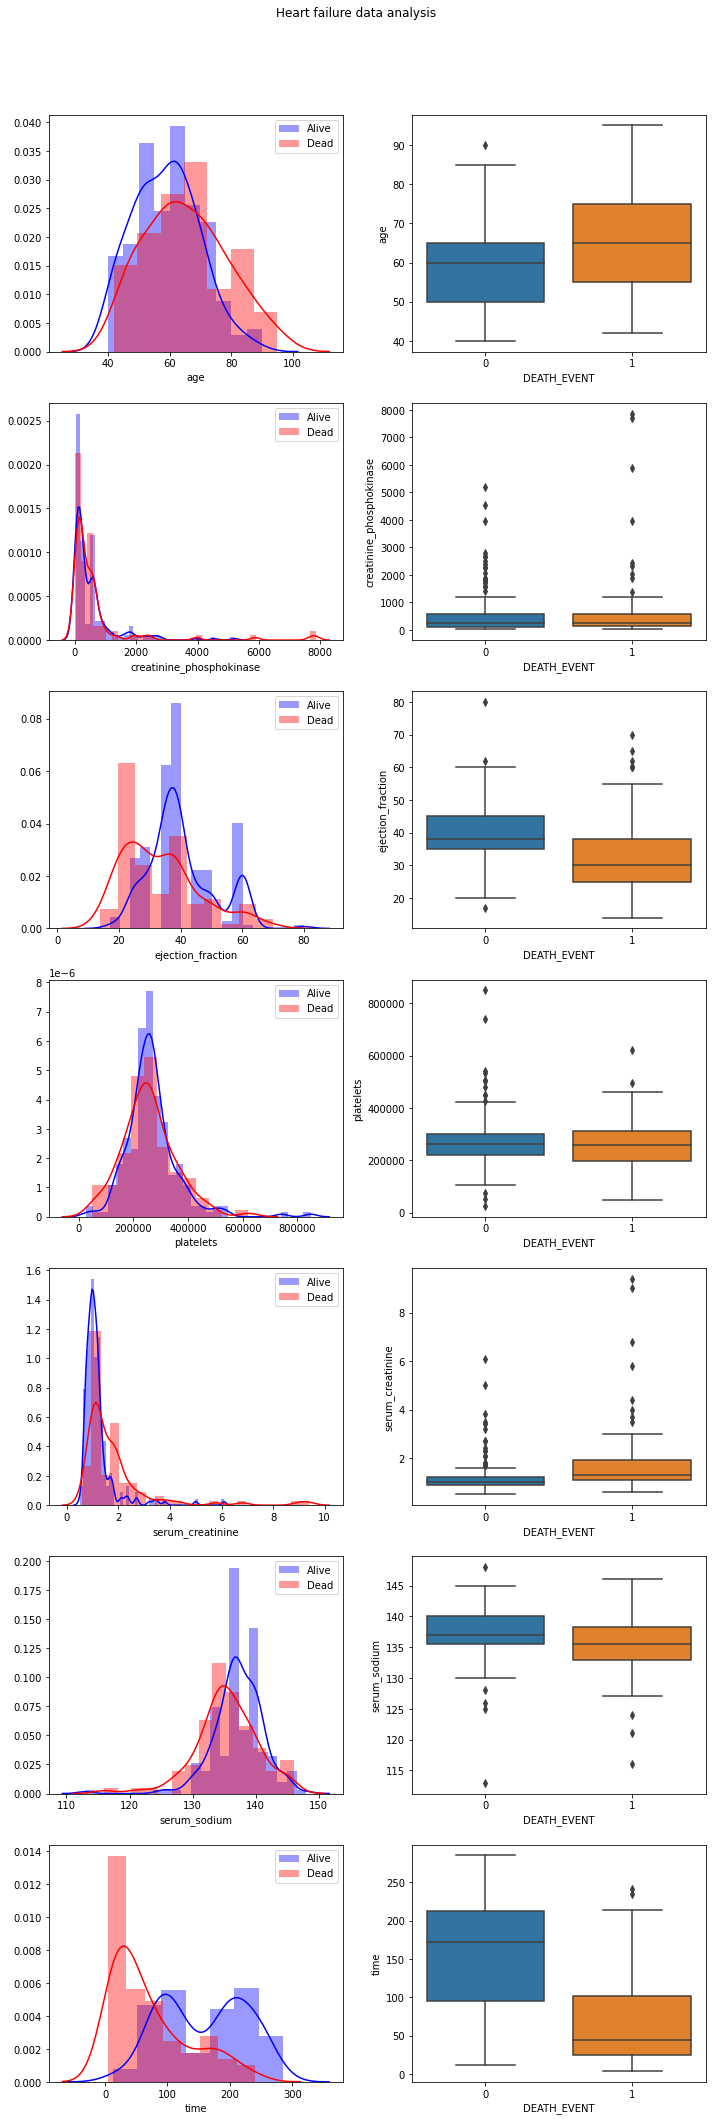

In [63]:
#Visualizing the selected features

fig = plt.figure(figsize = (10, 50))
j = 0
for i in x_numerical_Df.columns:
    plt.subplot(12, 2, j+1)
    j += 1
    
    sns.distplot(x_numerical_Df[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(x_numerical_Df[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.subplot(12, 2, j+1)
    j += 1
    sns.boxplot(x='DEATH_EVENT', y=x_numerical_Df[i], data=df)

fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

From the figures it is possible to notice the presence of several outliers in particular in some body values related features.

Through a carefully study of the domain field I discovered that the outlier entries seems not to be impossible values for the considered features.

Therefore I concluded that it's very improbable for them to be data recoding errors (like for example a 1km for "height_measure" or 200 years old for "Age" measure).

For this reason I decided to keep them and going on with the analysis.



###Categorical features

In the following images the categorical features distribution over the target variable "DEATH_EVENT" is represented.

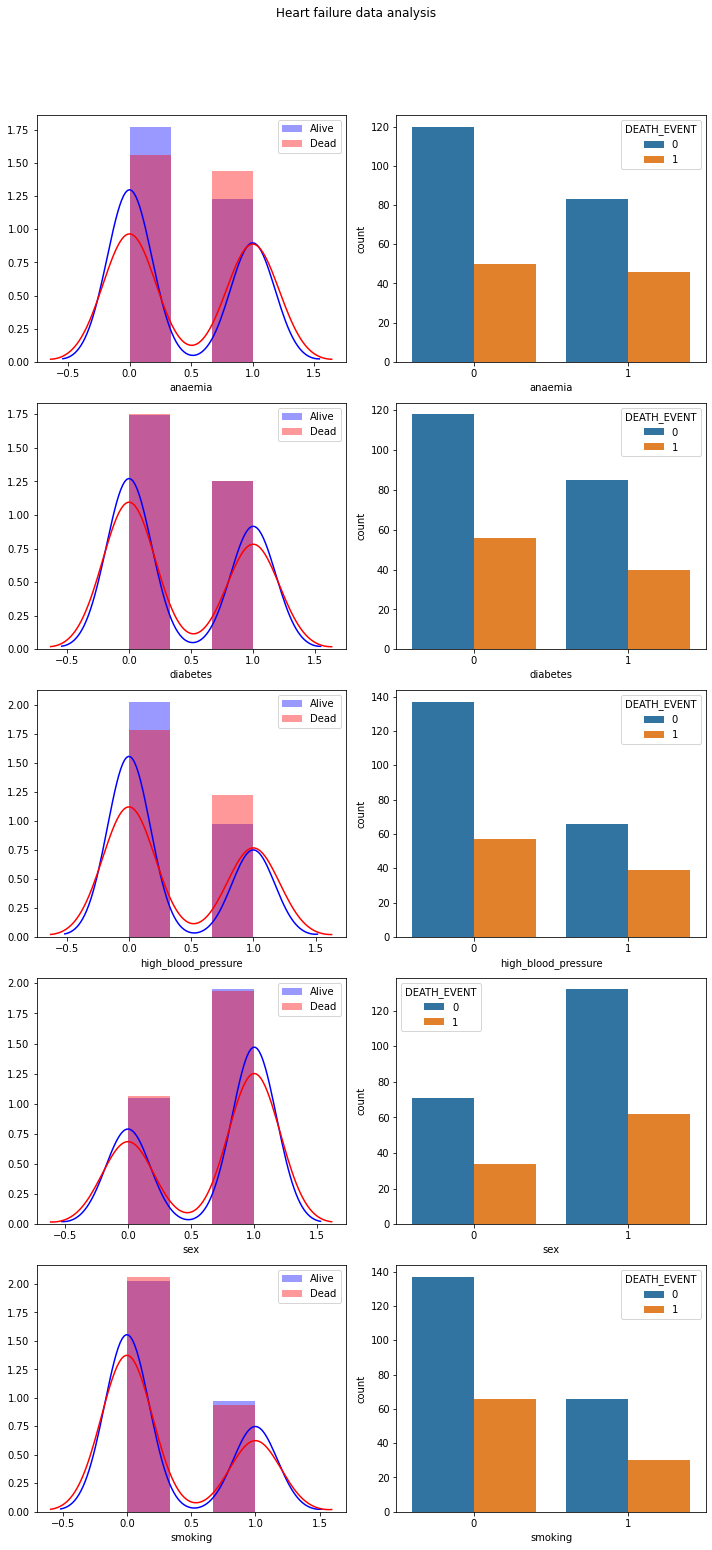

In [64]:
fig = plt.figure(figsize = (10, 50))
j = 0
for i in x_categorical_Df.columns:
    plt.subplot(12, 2, j+1)
    j += 1
    
    sns.distplot(x_categorical_Df[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(x_categorical_Df[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.subplot(12, 2, j+1)
    j += 1
    sns.countplot(x = x_categorical_Df[i], hue = 'DEATH_EVENT', data = df)

fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

From the plots above it is possible to notice that in each of them there are more "Alive" people than "Death".

This can be interpreted as an alarm signal for a possible class imbalance.

#Feature selection

--> inserisci il chisquare for categorical
--> e un metodo per selezionare le numeriche

#Check dataset unbalance

Since in the categorical features distribution plots a possible class unbalance was detected in this section a further investigation on this topic is carried on.

To try to discover if the dataset is potentially unbalanced I count the records having "DEATH_EVENT"==0 and the those having "DEATH_EVENT"==1.

The result is displayed in the following countplot:


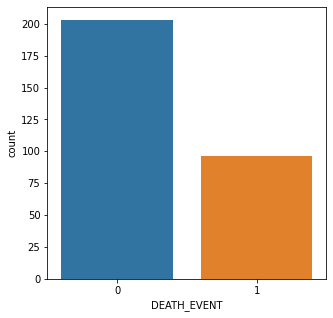

In [65]:
fig = plt.figure(figsize = (5, 5))
sns.countplot(x = 'DEATH_EVENT', data = df)

From the plot it is possible to notice that there are way more people labelled as "Alive" ("DEATH_EVENT"==0) than those labelled as "Dead" ("DEATH_EVENT"==1).

For this reason I decided to apply **SMOTE** oversampling tecnique on the part of the dataset designed as **training set** for the classifiers in order to try to rebalance it.


The name "SMOTE" stands for "Synthetic Minority Oversampling Technique" and is a way to add synthetic data to the minority represented class.

It's way of working can be summarized in the following steps:
- A random example from the minority class is first chosen. 
- k of the nearest neighbors for that example are found. 
- A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.



#Data standardization

After a closer look to the data visualization table presented above it is possible to notice that features have different units of measurement.

Theory states that variables that are measured at different scales don't contribute equally to the analysis and might end up creating bias.

In order to avoid this issue a standardization of the data is performed.

--> theory standardization

The result is shown in the following table:

In [66]:
# Standardizing the features (total, numerical and categorical)
x = StandardScaler().fit_transform(x)
x_st_Df = pd.DataFrame(data = x, columns = features)

totalDf = pd.concat([x_st_Df, y_df], axis = 1)

totalDf


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,-1.629502,1
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,-1.603691,1
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,-1.590785,1
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,-1.590785,1
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,-1.577879,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,1.803451,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1.816357,0
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1.906697,0
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,1.932509,0


#Define some useful function for smote

In [67]:
def nearest_neighbour(X, x):
    euclidean = np.ones(X.shape[0]-1)
    
    additive = [None]*(1*X.shape[1])
    additive = np.array(additive).reshape(1, X.shape[1])
    k = 0
    for j in range(0,X.shape[0]):
        if np.array_equal(X[j], x) == False:
            euclidean[k] = sqrt(sum((X[j]-x)**2))
            k = k + 1
    euclidean = np.sort(euclidean)
    weight = rand.random()
    while(weight == 0):
        weight = rand.random()
    additive = np.multiply(euclidean[:1],weight)
    return additive
    
def SMOTE_100(X):
    new = [None]*(X.shape[0]*X.shape[1])
    new = np.array(new).reshape(X.shape[0],X.shape[1])
    k = 0
    for i in range(0,X.shape[0]):
        additive = nearest_neighbour(X, X[i])
        for j in range(0,1):
            new[k] = X[i] + additive[j]
            k = k + 1
    return new 

#Data preparation
In all classifiers I will use k-fold cross validation in order to increase the performances and reduce overfitting
I divide the dataset into training set (80%) and test set (20%)

In [68]:
x_train_noPca, x_test_noPca, y_train_noPca, y_test_noPca = train_test_split(x, y, test_size = 0.2)

x_train_Df = pd.DataFrame(data = x_train_noPca, columns = features)
y_train_Df =pd.DataFrame(data=y_train_noPca, columns= ["DEATH_EVENT"])


trainDf = pd.concat([x_train_Df, y_train_Df], axis = 1)



#Standard validation

In [69]:
x_train_noPca, x_val_noPca, y_train_noPca, y_val_noPca = train_test_split(x_train_noPca,y_train_noPca,test_size= 0.2 )


##Classifiers evaluation on original dataset

###Linear SVM

In [70]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  
  
  clf=svm.SVC(kernel='linear', C=C)
  clf.fit(x_train_noPca,y_train_noPca.ravel()) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_val_noPca)
  accuracy= accuracy_score(y_val_noPca,y_p_SVM)
  
    
  #get the mean of the accuracies for each fold
  print("accuracy of the model:",accuracy)
  

  #searching for the best hyperparameter in the fold
  if (accuracy>acc_best):
    C_best=C
    acc_best=accuracy
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))

acc_original[0]=acc_on_Test
f1_original[0]=f1_on_Test

analyzing C=0.001
accuracy of the model: 0.7291666666666666
analyzing C=0.01
accuracy of the model: 0.7708333333333334
analyzing C=0.1
accuracy of the model: 0.75
analyzing C=1
accuracy of the model: 0.6666666666666666
analyzing C=10
accuracy of the model: 0.6666666666666666
analyzing C=100
accuracy of the model: 0.6666666666666666
analyzing C=1000
accuracy of the model: 0.6666666666666666


Best hyperparameter for the model is C=0.01
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7833333333333333
Precision on test set=0.7968460111317255
Recall on test set=0.7
F1 score on test set=0.7172888727799928


###RBF Kernel SVM
In order to try to increase the overall accuracy I try to apply the kernel trick.

In [71]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  
  clf=svm.SVC(kernel='rbf', C=C)
  clf.fit(x_train_noPca,y_train_noPca.ravel()) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_val_noPca)
  accuracy= accuracy_score(y_val_noPca,y_p_SVM)
  

  #get the mean of the accuracies for each fold
  print("total accuracy of the model is:",accuracy)
  

  #searching for the best hyperparameter in the fold
  if (accuracy>acc_best):
    C_best=C
    acc_best=accuracy
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_noPca)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original[1]=acc_on_Test
f1_original[1]=f1_on_Test

analyzing C=0.001
total accuracy of the model is: 0.7291666666666666
analyzing C=0.01
total accuracy of the model is: 0.7291666666666666
analyzing C=0.1
total accuracy of the model is: 0.7291666666666666
analyzing C=1
total accuracy of the model is: 0.75
analyzing C=10
total accuracy of the model is: 0.7708333333333334
analyzing C=100
total accuracy of the model is: 0.75
analyzing C=1000
total accuracy of the model is: 0.75


Best hyperparameter for the model is C=10
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7333333333333333
Precision on test set=0.7083333333333334
Recall on test set=0.725
F1 score on test set=0.7129186602870814


###Logistic regression 

In [72]:
clf = LogisticRegression(random_state=0).fit(x_train_noPca,y_train_noPca.ravel())
y_p_LR=clf.predict(x_val_noPca)
accuracy= accuracy_score(y_val_noPca,y_p_LR)
#get the mean of the accuracies for each fold
print("total accuracy of the model:",accuracy)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original[2]=acc_on_Test
f1_original[2]=f1_on_Test


total accuracy of the model: 0.7291666666666666
Accuracy on test set=0.8166666666666667
Precision on test set=0.7930402930402931
Recall on test set=0.8
F1 score on test set=0.7962334053720284


###Random forest

In [73]:
clf = RandomForestClassifier(max_depth=10, random_state=0).fit(x_train_noPca,y_train_noPca.ravel())
y_p_RF=clf.predict(x_val_noPca)

acc= accuracy_score(y_val_noPca,y_p_RF)

#get the mean of the accuracies for each fold
print("total accuracy of the model is:",acc)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original[3]=acc_on_Test
f1_original[3]=f1_on_Test


total accuracy of the model is: 0.8125
Accuracy on test set=0.85
Precision on test set=0.8296703296703296
Recall on test set=0.8375
F1 score on test set=0.8332818771225687


##Classifiers with smote oversampling tecnique

###Linear SVM

In [74]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  

  #apply smote
  unique, counts = np.unique(y_train_noPca, return_counts=True)
  minority_shape = dict(zip(unique, counts))[1]
  x1 = np.ones((minority_shape, x_train_noPca.shape[1]))
  k=0
  for i in range(0,x_train_noPca.shape[0]):
      
      if y_train_noPca[i] == 1:
          
          x1[k] = x_train_noPca[i]
          k = k + 1
  sampled_instances = SMOTE_100(x1)
  X_f = np.concatenate((x_train_noPca,sampled_instances), axis = 0)
  y_sampled_instances = np.ones(minority_shape)
  
  y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)
  #train the data on the training set
  clf=svm.SVC(kernel='linear', C=C)
  clf.fit(X_f,y_f) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_val_noPca)
  acc= accuracy_score(y_val_noPca,y_p_SVM)
  
  
  print("total accuracy of the model is:",acc)
  

  #searching for the best hyperparameter in the fold
  if (acc>acc_best):
    C_best=C
    acc_best=acc
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[0]=acc_on_Test
f1_smote[0]=f1_on_Test


analyzing C=0.001
total accuracy of the model is: 0.7291666666666666
analyzing C=0.01
total accuracy of the model is: 0.7291666666666666
analyzing C=0.1
total accuracy of the model is: 0.7083333333333334
analyzing C=1
total accuracy of the model is: 0.7916666666666666
analyzing C=10
total accuracy of the model is: 0.7083333333333334
analyzing C=100
total accuracy of the model is: 0.7083333333333334
analyzing C=1000
total accuracy of the model is: 0.7291666666666666


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.8166666666666667
Precision on test set with smote=0.7971428571428572
Recall on test set with smote=0.825
F1 score on test set with smote=0.8044444444444445


###RBF Kernel SVM

In [75]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  #apply smote
  unique, counts = np.unique(y_train_noPca, return_counts=True)
  minority_shape = dict(zip(unique, counts))[1]
  x1 = np.ones((minority_shape, x_train_noPca.shape[1]))
  k=0
  for i in range(0,x_train_noPca.shape[0]):
      
      if y_train_noPca[i] == 1:
        x1[k] = x_train_noPca[i]
        k = k + 1
  sampled_instances = SMOTE_100(x1)
  X_f = np.concatenate((x_train_noPca,sampled_instances), axis = 0)
  y_sampled_instances = np.ones(minority_shape)
  y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)



  #train the data on the training set
  clf=svm.SVC(kernel='rbf', C=C)
  clf.fit(X_f,y_f) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_val_noPca)
  acc= accuracy_score(y_val_noPca,y_p_SVM)
  

  #get the mean of the accuracies for each fold
  print("total accuracy of the model is:",acc)
  

  #searching for the best hyperparameter in the fold
  if (acc>acc_best):
    C_best=C
    acc_best=acc
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_noPca)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[1]=acc_on_Test
f1_smote[1]=f1_on_Test

analyzing C=0.001
total accuracy of the model is: 0.7291666666666666
analyzing C=0.01
total accuracy of the model is: 0.7291666666666666
analyzing C=0.1
total accuracy of the model is: 0.75
analyzing C=1
total accuracy of the model is: 0.6666666666666666
analyzing C=10
total accuracy of the model is: 0.7291666666666666
analyzing C=100
total accuracy of the model is: 0.75
analyzing C=1000
total accuracy of the model is: 0.6875


Best hyperparameter for the model is C=0.1
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.7666666666666667
Precision on test set with smote=0.7380952380952381
Recall on test set with smote=0.725
F1 score on test set with smote=0.730423620025674


###Logistic regression

In [76]:

#apply smote
unique, counts = np.unique(y_train_noPca, return_counts=True)
minority_shape = dict(zip(unique, counts))[1]
x1 = np.ones((minority_shape, x_train_noPca.shape[1]))
k=0
for i in range(0,x_train_noPca.shape[0]):
    
    if y_train_noPca[i] == 1:
        
        x1[k] = x_train_noPca[i]
        k = k + 1
sampled_instances = SMOTE_100(x1)
X_f = np.concatenate((x_train_noPca,sampled_instances), axis = 0)
y_sampled_instances = np.ones(minority_shape)
y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)




clf = LogisticRegression(random_state=0).fit(X_f,y_f)
y_p_LR=clf.predict(x_val_noPca)
acc= accuracy_score(y_val_noPca,y_p_LR)

#get the mean of the accuracies for each fold
print("total accuracy of the model is:",acc)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set= with smote{}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[2]=acc_on_Test
f1_smote[2]=f1_on_Test

total accuracy of the model is: 0.7291666666666666
Accuracy on test set with smote=0.8166666666666667
Precision on test set= with smote0.7930402930402931
Recall on test set with smote=0.8
F1 score on test set with smote=0.7962334053720284


###Random forest

In [77]:
#apply smote
unique, counts = np.unique(y_train_noPca, return_counts=True)
minority_shape = dict(zip(unique, counts))[1]
x1 = np.ones((minority_shape, x_train_noPca.shape[1]))
k=0
for i in range(0,x_train_noPca.shape[0]):
    
    if y_train_noPca[i] == 1:
        
        x1[k] = x_train_noPca[i]
        k = k + 1
sampled_instances = SMOTE_100(x1)
X_f = np.concatenate((x_train_noPca,sampled_instances), axis = 0)
y_sampled_instances = np.ones(minority_shape)
y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)


clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_f,y_f)
y_p_RF=clf.predict(x_val_noPca)


acc= accuracy_score(y_val_noPca,y_p_RF)

#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",acc)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[3]=acc_on_Test
f1_smote[3]=f1_on_Test

total accuracy of the model after Cross Validation is: 0.8125
Accuracy on test set with smote=0.8
Precision on test set with smote=0.7749999999999999
Recall on test set with smote=0.7749999999999999
F1 score on test set with smote=0.7749999999999999


#KFold Cross Validation

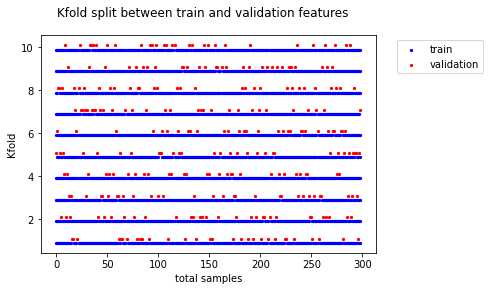

In [78]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize2(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize2(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="validation",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and validation features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

##Classifiers evaluation on original dataset

###Linear SVM

In [79]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each C
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))

acc_original_cv[0]=acc_on_Test
f1_original_cv[0]=f1_on_Test


analyzing C=0.001
total accuracy of the model after Cross Validation is: 68.2427536231884
analyzing C=0.01
total accuracy of the model after Cross Validation is: 70.63405797101449
analyzing C=0.1
total accuracy of the model after Cross Validation is: 80.70652173913044
analyzing C=1
total accuracy of the model after Cross Validation is: 80.76086956521739
analyzing C=10
total accuracy of the model after Cross Validation is: 81.19565217391305
analyzing C=100
total accuracy of the model after Cross Validation is: 81.19565217391302
analyzing C=1000
total accuracy of the model after Cross Validation is: 80.7427536231884


Best hyperparameter for the model is C=10
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7666666666666667
Precision on test set=0.7375
Recall on test set=0.7375
F1 score on test set=0.7375


###RBF Kernel SVM
In order to try to increase the overall accuracy I try to apply the kernel trick.

As before I apply it using cross validation to reduce overfitting

In [80]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_noPca)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original_cv[1]=acc_on_Test
f1_original_cv[1]=f1_on_Test

analyzing C=0.001
total accuracy of the model after Cross Validation is: 68.22463768115942
analyzing C=0.01
total accuracy of the model after Cross Validation is: 68.22463768115942
analyzing C=0.1
total accuracy of the model after Cross Validation is: 68.11594202898551
analyzing C=1
total accuracy of the model after Cross Validation is: 79.13043478260869
analyzing C=10
total accuracy of the model after Cross Validation is: 75.30797101449276
analyzing C=100
total accuracy of the model after Cross Validation is: 76.9927536231884
analyzing C=1000
total accuracy of the model after Cross Validation is: 74.45652173913044


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.8
Precision on test set=0.7749999999999999
Recall on test set=0.7749999999999999
F1 score on test set=0.7749999999999999


linear SVM model performs better

###Logistic regression 

In [81]:

fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']


      clf = LogisticRegression(random_state=0).fit(X_train,y_train)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original_cv[2]=acc_on_Test
f1_original_cv[2]=f1_on_Test

total accuracy of the model after Cross Validation is: 81.99275362318842
Accuracy on test set=0.7833333333333333
Precision on test set=0.7585193889541716
Recall on test set=0.775
F1 score on test set=0.7644216248867413


###Random forest

In [82]:

fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train,y_train)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original_cv[3]=acc_on_Test
f1_original_cv[3]=f1_on_Test


total accuracy of the model after Cross Validation is: 83.29710144927537
Accuracy on test set=0.8833333333333333
Precision on test set=0.8722721437740693
Recall on test set=0.8625
F1 score on test set=0.8670465337132003


##Classifiers with smote oversampling tecnique

###Linear SVM

In [83]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_f,y_f) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

acc_smote_cv[0]=acc_on_Test
f1_smote_cv[0]=f1_on_Test


analyzing C=0.001
total accuracy of the model after Cross Validation is: 69.8913043478261
analyzing C=0.01
total accuracy of the model after Cross Validation is: 76.97463768115942
analyzing C=0.1
total accuracy of the model after Cross Validation is: 77.80797101449275
analyzing C=1
total accuracy of the model after Cross Validation is: 78.2427536231884
analyzing C=10
total accuracy of the model after Cross Validation is: 79.09420289855072
analyzing C=100
total accuracy of the model after Cross Validation is: 80.32608695652173
analyzing C=1000
total accuracy of the model after Cross Validation is: 82.01086956521738


Best hyperparameter for the model is C=1000
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.8166666666666667
Precision on test set with smote=0.7937720329024677
Recall on test set with smote=0.8125
F1 score on test set with smote=0.8006644518272426


###RBF Kernel SVM

In [84]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)
    

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_f,y_f) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_noPca)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

acc_smote_cv[1]=acc_on_Test
f1_smote_cv[1]=f1_on_Test

analyzing C=0.001
total accuracy of the model after Cross Validation is: 68.2427536231884
analyzing C=0.01
total accuracy of the model after Cross Validation is: 61.52173913043478
analyzing C=0.1
total accuracy of the model after Cross Validation is: 76.19565217391305
analyzing C=1
total accuracy of the model after Cross Validation is: 79.07608695652175
analyzing C=10
total accuracy of the model after Cross Validation is: 74.89130434782606
analyzing C=100
total accuracy of the model after Cross Validation is: 74.87318840579708
analyzing C=1000
total accuracy of the model after Cross Validation is: 69.05797101449275


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.7666666666666667
Precision on test set with smote=0.7392344497607655
Recall on test set with smote=0.75
F1 score on test set with smote=0.7435897435897436


###Logistic regression

In [85]:
fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)




      clf = LogisticRegression(random_state=0).fit(X_f,y_f)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set= with smote{}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote_cv[2]=acc_on_Test
f1_smote_cv[2]=f1_on_Test

total accuracy of the model after Cross Validation is: 77.46376811594202
Accuracy on test set with smote=0.7833333333333333
Precision on test set= with smote0.7564102564102564
Recall on test set with smote=0.7625
F1 score on test set with smote=0.7591849336214881


###Random forest

In [86]:
fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values


      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_f,y_f)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

acc_smote_cv[3]=acc_on_Test
f1_smote_cv[3]=f1_on_Test

total accuracy of the model after Cross Validation is: 84.8913043478261
Accuracy on test set with smote=0.8666666666666667
Precision on test set with smote=0.8500000000000001
Recall on test set with smote=0.8500000000000001
F1 score on test set with smote=0.8500000000000001


#Results

In [87]:



result_Table =pd.DataFrame({'model': ['Linear SVM', 'RBF Kernel SVM','Logistic Regression','Random Forest'], 'Holdout Original Accuracy': acc_original, 'Holdout Original F1': f1_original, 'Holdout SMOTE Accuracy': acc_smote, 'Holdout SMOTE F1': f1_smote, 'Holdout Original CV Accuracy':acc_original_cv, 'Holdout Original CV F1': f1_original_cv, 'Holdout SMOTE CV Accuracy': acc_smote_cv,'Holdout SMOTE CV F1': f1_smote_cv})
result_Table

,model,Holdout Original Accuracy,Holdout Original F1,Holdout SMOTE Accuracy,Holdout SMOTE F1,Holdout Original CV Accuracy,Holdout Original CV F1,Holdout SMOTE CV Accuracy,Holdout SMOTE CV F1
0,Linear SVM,0.783333,0.717289,0.816667,0.804444,0.766667,0.737500,0.816667,0.800664
1,RBF Kernel SVM,0.733333,0.712919,0.766667,0.730424,0.800000,0.775000,0.766667,0.743590
2,Logistic Regression,0.816667,0.796233,0.816667,0.796233,0.783333,0.764422,0.783333,0.759185
3,Random Forest,0.850000,0.833282,0.800000,0.775000,0.883333,0.867047,0.866667,0.850000
